<a href="https://colab.research.google.com/github/dwu926/Problem-Management-UI/blob/master/E_commerce_Purchase_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving online_shopping_data.csv to online_shopping_data (1).csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression ,LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,RobustScaler,LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

from collections import Counter
from sklearn.utils import resample

from IPython.display import display
pd.set_option('display.max_columns', 60)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.style.use('fivethirtyeight')

import random
random.seed(9001)

In [24]:
data = pd.read_csv('online_shopping_data.csv')
df = data.copy()
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# Prep analysis the data`

In [4]:
# checking if any of the attributes are empty 
pd.DataFrame({'Count_Missing' : df.isnull().sum(), 'Percentage_Missing' : 100*df.isnull().sum()/len(df)}).sort_values(by = ['Count_Missing'], ascending=False).head(20)

,Count_Missing,Percentage_Missing
Administrative,0,0.0
Administrative_Duration,0,0.0
Weekend,0,0.0
VisitorType,0,0.0
TrafficType,0,0.0
Region,0,0.0
Browser,0,0.0
OperatingSystems,0,0.0
Month,0,0.0
SpecialDay,0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [6]:
# checking all the unstructured data
print(Counter(df['Month']))
print(Counter(df['VisitorType']))
print(Counter(df['Weekend']))
print(Counter(df['Revenue']))

Counter({'May': 3364, 'Nov': 2998, 'Mar': 1907, 'Dec': 1727, 'Oct': 549, 'Sep': 448, 'Aug': 433, 'Jul': 432, 'June': 288, 'Feb': 184})
Counter({'Returning_Visitor': 10551, 'New_Visitor': 1694, 'Other': 85})
Counter({False: 9462, True: 2868})
Counter({False: 10422, True: 1908})


In [7]:
# checking all the structured data
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


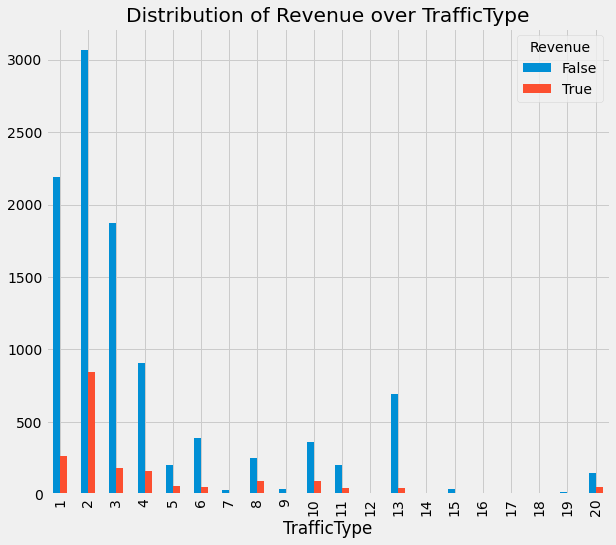

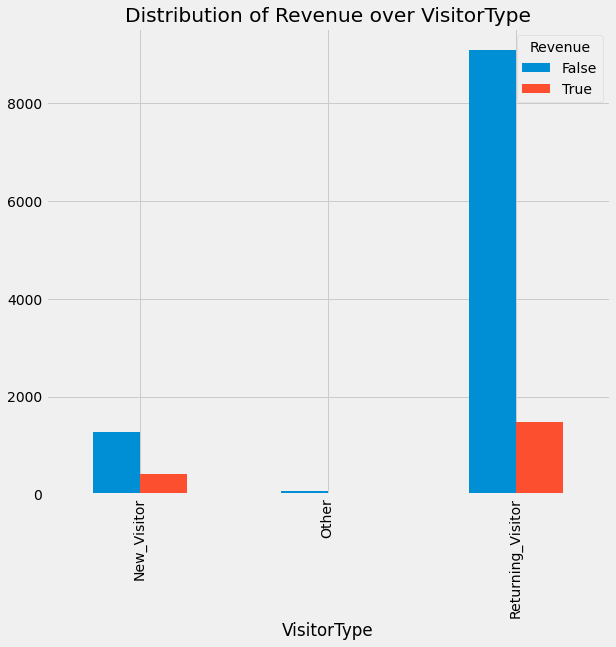

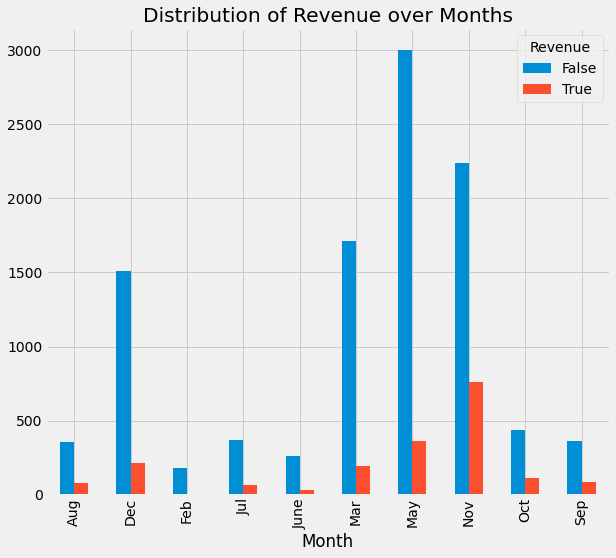

In [8]:
# making some plots to get some insight about the affection of different attributes to the purchase

pd.crosstab(df['TrafficType'],df['Revenue']).plot(kind='bar',figsize=(9,8),title="Distribution of Revenue over TrafficType")

pd.crosstab(df['VisitorType'],df['Revenue']).plot(kind='bar',figsize=(9,8),title="Distribution of Revenue over VisitorType")

pd.crosstab(df['Month'],df['Revenue']).plot(kind='bar',figsize=(9,8),title="Distribution of Revenue over Months")

plt.show()

# Preprocessing the data and ready for modeling
# Feature Engineering

In [25]:
# using dummy/One Hot Encoding
df = pd.get_dummies( df, columns = ['VisitorType','Month'])
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,1,2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,1,9,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,2,2,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,3,1,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0


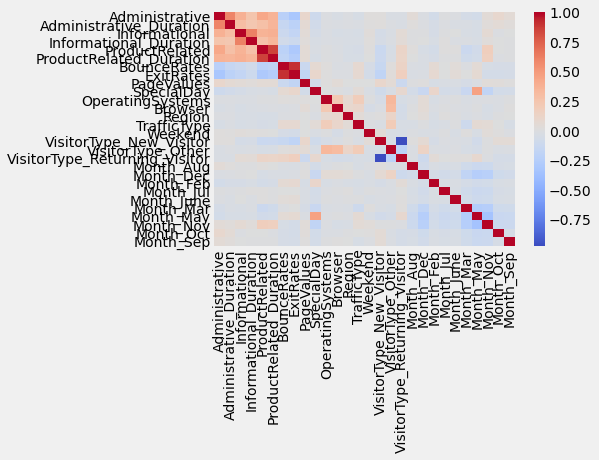

In [29]:
# Checking for Collinearity Between Features
X = df.drop('Revenue', axis=1)
Y = df['Revenue']
corr_coeff = X.corr()
sns.heatmap(corr_coeff, xticklabels=corr_coeff.columns,yticklabels=corr_coeff.columns, cmap='coolwarm')

Looks like there are some correlation between 

1.   "Administrative", "Administrative Duration"
2.   "Informational", "Informational Duration"
3.    "Product Related" and
"Product Related Duration" 

So we can reduec the features by generating new features such as (AvgAdministrativeDuration = Administrative Duration / Administrative)




,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,AvgAdminDura,AvgInformDura,AvgProdDura
0,0.20,0.20,0.0,0.0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.000000
1,0.00,0.10,0.0,0.0,2,2,1,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,32.000000
2,0.20,0.20,0.0,0.0,4,1,9,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.000000
3,0.05,0.14,0.0,0.0,3,2,2,4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,1.333333
4,0.02,0.05,0.0,0.0,3,3,1,4,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0.0,0.0,62.750000


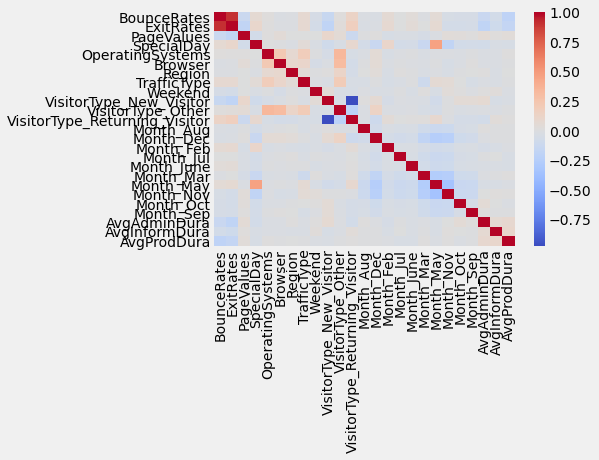

In [30]:
n = len(df)
def avgdura(duration, count):
  if count != 0:
    return duration/count
  else:
    return 0
  
X["AvgAdminDura"] = [avgdura(X['Administrative_Duration'][i], X['Administrative'][i]) for i in range(n)]
X["AvgInformDura"] = [avgdura(X['Informational_Duration'][i], X['Informational'][i]) for i in range(n)]
X["AvgProdDura"] = [avgdura(X['ProductRelated_Duration'][i], X['ProductRelated'][i]) for i in range(n)]
X.drop(['Administrative', 'Administrative_Duration','Informational', 
        'Informational_Duration','ProductRelated', 'ProductRelated_Duration'],axis = 1, inplace = True)
X.head()
corr_coeff = X.corr()
sns.heatmap(corr_coeff, xticklabels=corr_coeff.columns,yticklabels=corr_coeff.columns, cmap='coolwarm')


12330